In [1]:
import sys
sys.executable

'/Applications/anaconda3/envs/kidney/bin/python'

In [2]:
# from bs4 import BeautifulSoup
import numpy as np
from collections import Counter
import pandas as pd
import os
import re
import json
import openslide
from matplotlib import pyplot as plt
import cv2

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../slideslicer/')

In [4]:
from extract_rois_svs_xml import RoiReader, extract_rois_svs_xml, get_threshold_tissue_mask
from slideutils import (plot_contour, get_median_color, get_thumbnail_magnification,
#                        get_img_bbox, get_rotated_highres_roi, get_uniform_tiles,
#                        get_contour_centre, clip_roi_wi_bbox,
                        read_roi_patches_from_slide,
                       convert_mask2contour, 
                        get_roi_dict,
                       sample_points_wi_contour)

## Background

The histologic slides are huge. Loading a whole slide into memory might be not the best idea. Here we use some tricks to sample tissue based on hand-labelled features as well as grid sampling in combination with color thresholding (to remove blank space)

## Read XML ROI, convert, and save as JSON

In [5]:
# fnxml  = "/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.xml"
fnxml  = "/Users/dlituiev/repos/kidney_histopath/data/raw/7b1f872d00041bfa4a316bb765e596f9be05931d.xml"
fnsvs = re.sub(".xml$", ".svs", fnxml)

In [6]:
fnsvs

'/Users/dlituiev/repos/kidney_histopath/data/raw/7b1f872d00041bfa4a316bb765e596f9be05931d.svs'

In [7]:
!ls  /Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.svs

/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.svs


In [8]:
re.sub(".svs$", "", re.sub(".xml$", "", fnxml))

'/Users/dlituiev/repos/kidney_histopath/data/raw/7b1f872d00041bfa4a316bb765e596f9be05931d'

In [9]:
rreader = RoiReader(fnxml, threshold_tissue=True, save=True)

counts of roi names
infl      14
tissue     4
dtype: int64
counts of roi names after removing empty chunks
infl      14
tissue     2
dtype: int64


([], <a list of 0 Text yticklabel objects>)

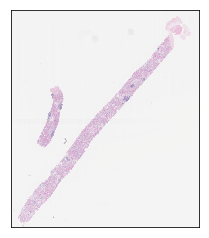

In [87]:
plt.imshow(rreader.load_thumbnail())
plt.xticks([])
plt.yticks([])

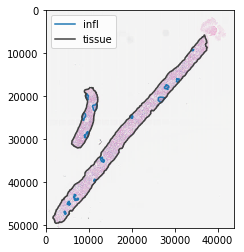

In [10]:
rreader.plot(labels=False)
plt.legend(loc='upper left')#, bbox_to_anchor=(1, 0.5))

In [11]:
slide = rreader.slide

In [48]:
%%timeit -n 50
img_ = rreader.get_patch(11880, 21700, 512, target_subsample=30)
pass

15.7 ms ± 958 µs per loop (mean ± std. dev. of 7 runs, 50 loops each)


In [71]:
timing_get_patch = """1 : 33.3 ms ± 1.56 ms,
    2 : 40.6 ms ± 1.47 ms,
    4 : 16.9 ms ± 1.17 ms,
    6 : 17.2 ms ± 0.74 ms,
    8 : 18.3 ms ± 1.53 ms,
    10: 17.4 ms ± 0.83 ms,
    12: 17.7 ms ± 0.70 ms,
    16: 16.4 ms ± 1.25 ms,
    20: 18.4 ms ± 2.08 ms,
    24: 16 ms ± 1.09 ms,
    30: 15.7 ms ± 0.96 ms
    32: 17 ms ± 1.43 ms"""
timing_get_patch = [x.strip(',').strip().split(':') for x in timing_get_patch.split('\n')]
timing_get_patch = {int(kk.strip()):vv.strip().split(' ± ') for kk,vv in timing_get_patch}

In [72]:
timing_get_patch = pd.DataFrame(timing_get_patch,
                               ).T.applymap(lambda x: float(x.replace('ms', '').strip()))
timing_get_patch.columns = ['mean', 'stderr']

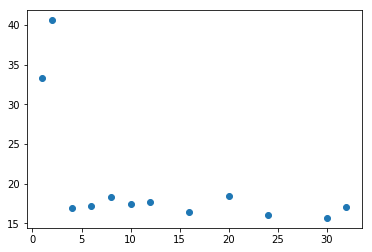

In [78]:
plt.scatter(timing_get_patch.index, timing_get_patch['mean'])

In [ ]:
    1: 8.23 ms ± 0.858 ms
    2: 8.84 ms ± 1.5 ms
    4: 7.96 ms ± 1.2 ms
    8: 8.24 ms ± 1.38

In [84]:
%%timeit -n 50
rreader.get_patch_rois(11880, 21700, 512, target_subsample=8)
pass

8.24 ms ± 1.38 ms per loop (mean ± std. dev. of 7 runs, 50 loops each)


infl
tissue


(<Figure size 432x288 with 1 Axes>,
 <PIL.Image.Image image mode=RGBA size=256x256 at 0x128D87D30>,
     analyze          area   areamicrons  displayid  id  imagefocus  \
 1       1.0   9731.500000  6.922150e+04        2.0   2         0.0   
 14      NaN  40961.764688  2.316658e+06        NaN  15         NaN   
 
    imagelocation  inputregionid  length  lengthmicrons    name  negativeroa  \
 1                           0.0  4693.1         1185.0    infl          0.0   
 14           NaN            NaN     NaN            NaN  tissue          NaN   
 
     selected  type                                           vertices  \
 1        0.0   0.0  [[0.0, 254.5], [0.0, 256.0], [159.5, 256.0], [...   
 14       NaN   NaN  [[0.0, 0.0], [0.0, 256.0], [171.17657444566885...   
 
         zoom                                            polygon  
 1   0.144946  POLYGON ((0 254.5, 0 256, 159.5 256, 159.5 254...  
 14       NaN  POLYGON ((0 0, 0 256, 171.1765744456688 256, 1...  )

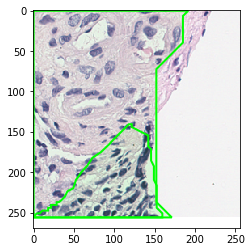

In [19]:
rreader.plot_patch(11880, 21700, 512, target_subsample=2)
pass

In [15]:
rreader

,counts
infl,14
tissue,2


In [35]:
vv['vertices']

66    [(7831.0, 12866.0), (7820.0, 12866.0), (7759.0...
Name: vertices, dtype: object

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10363c668>)

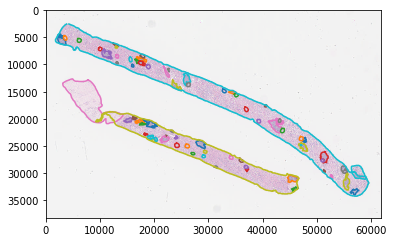

In [28]:
rreader.plot()

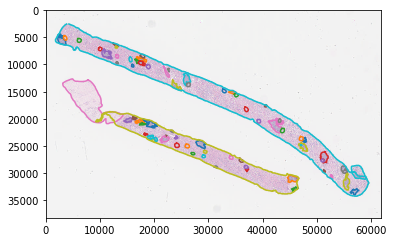

In [18]:
fig, ax = rreader.plot()

AttributeError: 'Figure' object has no attribute 'figsave'

70 ROIs
	from/Users/dlituiev/repos/kidney_histopath/data/raw/f7f931a5cf3185a385e9aa34e6e9a566fc88000c.svs;
        

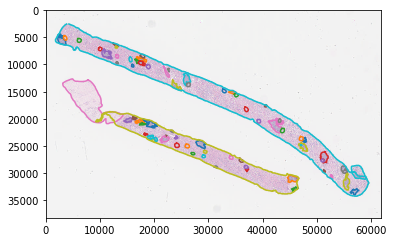

In [17]:
fig.savefig

In [13]:
# roir

In [25]:
roilist = roir.rois

In [15]:
roir.df[[ 'id', 'name', 'area', 
       'length',]].set_index('id')

,name,area,length
id,,,
1,infl,1729228.5,8163.4
2,open glom,406998.5,2475.8
3,open glom,434205.5,2431.2
4,open glom,326631.0,2080.4
5,infl,1741169.0,9939.7
6,infl,256747.5,2712.8
7,open glom,279915.5,1966.2
8,open glom,140857.5,1411.2
9,open glom,122101.0,1332.8


In [17]:
pd.Series([roi["name"] for roi in roilist]).value_counts()#.index

infl                                      33
open glom                                 33
tissue                                     2
capsular tissue                            1
tubular profile excluded from the infl     1
dtype: int64

## load the slide from SVS file

In [18]:
slide = openslide.OpenSlide(fnsvs)
img = np.asarray(slide.associated_images["thumbnail"])

median_color = get_median_color(slide)
ratio = get_thumbnail_magnification(slide)

In [19]:
slide.dimensions

(61752, 38280)

In [20]:
colordict = {'open glom': 'b',
             'glom': 'b',
             'scler glom': 'm',
             'infl':'r',
             'tissue':'k',
             'art':'olive',
             'fold':'y'}

number of chunks detected: 3


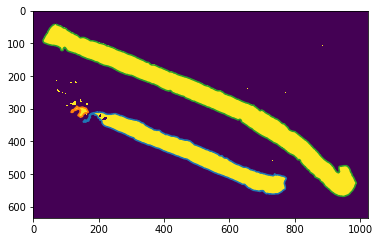

In [21]:
chunk_masks = get_threshold_tissue_mask(img)
chunk_countours = convert_mask2contour(chunk_masks, minlen=70)
print("number of chunks detected:", len(chunk_countours))

plt.imshow(chunk_masks)
for cc in chunk_countours:
    plot_contour(cc)

In [22]:
chunk_rois = [get_roi_dict(cc, name='tissue', id=1+nn+len(roilist), sq_micron_per_pixel=1.0)
                          for nn,cc in enumerate(chunk_countours)]
len(chunk_rois)

3

In [12]:
# tissue_rois = [roi for roi in roilist if roi["name"]=="tissue"]
# feature_rois = [roi for roi in roilist if roi["name"]!="tissue"]
# len(tissue_rois), len(feature_rois)

In [23]:
from shapely.geometry import Polygon

def _shapely_polygon_from_roi_(roi):
    return Polygon(roi["vertices"])

def find_chunk_content(roilist):
    """finds features (gloms, infl, etc) contained within tissue chunks.
    Returns a dictionary:
    {tissue_chunk_1_id: [feature_1_id, ..., feature_n_id],
     tissue_chunk_1_id: [...]
    }
    Requires `shapely` package
    """
    pgs_tissue = {}
    pgs_feature = {}
    for roi in roilist:
    #     print(roi['id'], roi['name'])
        if roi["name"]=="tissue":
            pgs_tissue[roi['id']] = Polygon(roi["vertices"])
        else:
            pgs_feature[roi['id']] = Polygon(roi["vertices"])
#     print(sorted(list(pgs_feature.keys())))
    tissue_contains = dict(zip(pgs_tissue.keys(), [[] for _ in range(len(pgs_tissue))]))
    remove_items = []
    for idt, pt in pgs_tissue.items():
        for idf in remove_items:
#             print("popping", idf)
            pgs_feature.pop(idf)
        remove_items = []
        for idf, pf in pgs_feature.items():
            if pt.intersects(pf):
                remove_items.append(idf)
                tissue_contains[idt].append(idf)
#         print(idt, remove_items, tissue_contains)
    return tissue_contains

def remove_empty_tissue_chunks(roilist):
    """removes tissue chunks that contain no annotation contours within"""
    chunk_content = find_chunk_content(roilist)
    empty_chunks = set([kk for kk,vv in chunk_content.items() if len(vv)==0])
    return [roi for roi in roilist if roi['id'] not in empty_chunks]

In [29]:
roilist_ = remove_empty_tissue_chunks(roilist)

In [30]:
dfroi = pd.DataFrame(roilist_)
dfroi["name"].value_counts()

infl                                      33
open glom                                 33
tissue                                     2
capsular tissue                            1
tubular profile excluded from the infl     1
Name: name, dtype: int64

In [36]:
dfroi['color'] = dfroi['name'].map(lambda x: colordict[x] if x in colordict else 'g')

In [85]:
# find_chunk_content(roilist)
# [(roi['id'], roi['name']) for roi in roilist]

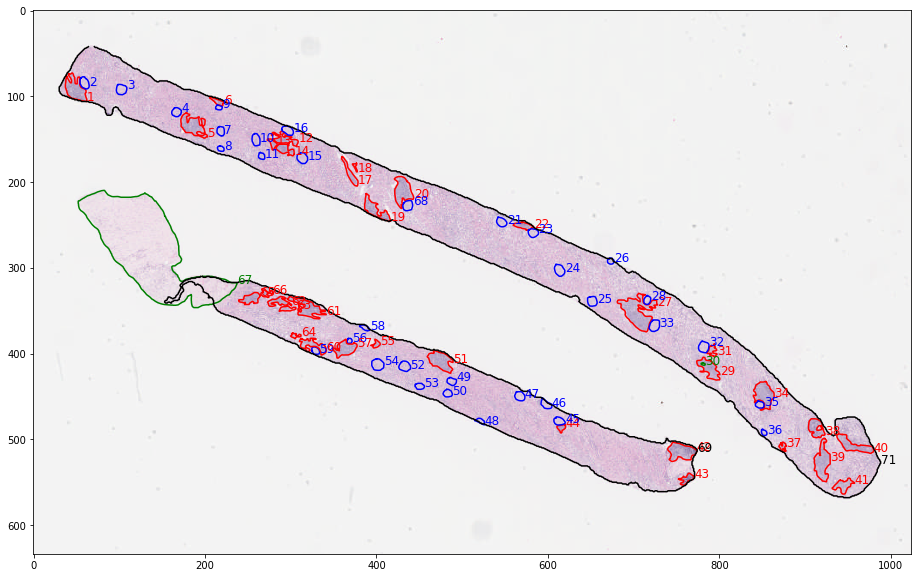

In [37]:
plt.figure(figsize = (18,10))
plt.imshow(img)
for _, roi in dfroi.iterrows():
    l = plot_contour(roi["vertices"]/ratio, c=roi['color'], name = roi['id'])

##  Sample patches based on rois of hand-labelled features (glomeruli, inflammation etc)

In [41]:
from slideutils import get_region_mask

In [42]:
print("reading targeted rois")

reading targeted rois


In [43]:
def rectangle_intersection(a,b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0]+a[2], b[0]+b[2]) - x
    h = min(a[1]+a[3], b[1]+b[3]) - y
    if w<0 or h<0: return None
    return (x, y, w, h)

In [15]:
# for roi in roilist:
#     roi['bbox'] = cv2.boundingRect(np.asarray(roi["vertices"]).round().astype(int))

In [16]:
# rect_list = [roi['bbox'] for roi in roilist]

In [17]:
# [roi['id'] for roi in roilist]

In [44]:
def get_img_id(svsname):
    imgid = re.sub("\.svs$","", os.path.basename(svsname)).replace(" ", "_").replace("-","_")
    return imgid


def get_prefix(imgid, pos, name, tissueid, id, parentdir = "data"):
    prefix = "{parentdir}/{typ}/{imgid}-{pos}-t{tissue}-r{roiid}-{typ}".format(**{
                                        "tissue":tissueid,
                                        "pos": "x{}-y{}".format(*pos),
                                        "parentdir":parentdir,
                                        "imgid":imgid,
                                        "roiid":id, 
                                        "typ": (name.replace(" ","_"))})
    return prefix

In [19]:
# ind = np.argmax([rr["area"] for rr in rois if rr['name'] !='tissue'])
# rois[ind]['name']

In [46]:
from PIL import Image
import json

In [47]:
for nn in set([rr["name"] for rr in  roilist]):
    nn = nn.replace(" ", "_")
    print(nn)
    os.makedirs("data/{}".format(nn), exist_ok=True)

tubular_profile_excluded_from_the_infl
infl
open_glom
capsular_tissue
tissue


In [48]:
imgid = get_img_id(fnsvs)

rr = roilist[0]
prefix = get_prefix(imgid, (0,0), rr["name"], "39", rr["id"])
fnoutpng = prefix + '.png'
fnoutpng

'data/infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x0-y0-t39-r1-infl.png'

In [49]:
def summarize_rois_wi_patch(rois, bg_names = ["tissue"]):
#     ind = np.argmax([rr["area"] for rr in rois if rr['name'] not in ignore_names])
    names = []
    areas = []
    ids = []
    
    tissue_info = []
    for rr in rois:
        if rr['name'] in bg_names:
            tissue_info.append(rr)
            continue
        names.append(rr['name'])
        areas.append(rr['area'])
        ids.append(rr['id'])
        
#     assert (len(tissue_info)==1)
    tissue_id = "+".join(["%s"%tt['id'] for tt in tissue_info])
#     print("tissue_info", tissue_id)
    
    dfareas = (pd.DataFrame(dict(area=areas, name=names, id=ids))
                     .sort_values("area", ascending=False)
               )
    areasum = (dfareas.groupby('name')
                     .agg({"area":sum, "id": "first"})
                     .sort_values("area", ascending=False)
              )
    if len(areasum)==1:
        name = areasum.index[0]
        id = areasum["id"][0]
    elif areasum["area"][0]/areasum["area"][1] > 3:
        name = areasum.index[0]
        id = areasum["id"][0]
    else:
#         name = None
        name = '+'.join(areasum.index.tolist())
        id = '+'.join(areasum["id"].astype(str).tolist())
    return {"name":name, "id": str(id), "tissue_id": tissue_id, "stats": dfareas.to_dict(orient='records')}

In [50]:
# roi_cropped_list

In [51]:
# for reg, rois in zip(img_arr, roi_cropped_list):
#     sumdict = summarize_rois_wi_patch(rois, bg_names = ["tissue"])
# #     print(sumdict)
#     prefix = get_prefix(imgid, sumdict["name"], sumdict["tissue_id"], sumdict["id"])
#     print(prefix)

In [52]:
# !rm data/infl/*

In [70]:
parentdir = "../data/data_1024/fullsplit/"
imgroiiter = read_roi_patches_from_slide(slide, roilist,
                        target_size = [1024]*2,
                        maxarea = 1e7,
                        nchannels=3,
                        allcomponents=True,
                       )

for reg, rois,_, start_xy in imgroiiter:
    sumdict = summarize_rois_wi_patch(rois, bg_names = ["tissue"])
    
#     name = sumdict["name"]
#     id = sumdict["id"]
#     prefix = get_prefix(imgid, sumdict["name"], sumdict["tissue_id"], sumdict["id"] )
    prefix = get_prefix(imgid, start_xy, sumdict["name"], sumdict["tissue_id"], sumdict["id"],
                       parentdir=parentdir)
    fnjson = prefix + ".json"
    os.makedirs(os.path.dirname(fnjson), exist_ok=True)
    
    with open(fnjson, 'w+') as fhj: json.dump( sumdict, fhj)
    fnoutpng = prefix + '.png'
    Image.fromarray(reg).save(fnoutpng)
    print("saving to\t%s" % fnoutpng)


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x2428-y5015-t71-r1-infl.png
saving to	../data/data_1024/fullsplit//open_glom+infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x3075-y4585-t71-r2+1-open_glom+infl.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x5669-y5043-t71-r3-open_glom.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x9548-y6641-t71-r4-open_glom.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x10706-y7582-t71-r5-infl.png


../slideslicer/slideutils.py:622: UserWarning: multiple pieces after intersection
using the largest piece

  """)


saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x12437-y5891-t71-r6+9-infl+open_glom.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x12661-y7972-t71-r7-open_glom.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x12661-y9209-t71-r8-open_glom.png
saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x12528-y6319-t71-r6+9-infl+open_glom.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x15141-y8587-t71-r10-open_glom.png


no vertices found	skipping	infl	13


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x15533-y9730-t71-r11-open_glom.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x17171-y8546-t71-r12-infl.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x16316-y8867-t71-r13-infl.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x17171-y9261-t71-r14-infl.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x18399-y9874-t71-r15-open_glom.png
saving to	../data/data_1024/fullsplit//open_glom+infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x17379-y7929-t71-r16+12-open_glom+infl.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x21788-y10994-t71-r17-infl.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x22115-y10480-t71-r17-infl.png
saving to	../data/data_1024/fullspl

no vertices found	skipping	tissue	69


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x36484-y17772-t71-r24-open_glom.png


no vertices found	skipping	tissue	69


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x38787-y19958-t71-r25-open_glom.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x40089-y17132-t71-r26-open_glom.png


no vertices found	skipping	tissue	69


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x41980-y20717-t71-r27-infl.png


no vertices found	skipping	tissue	69


saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x42655-y19877-t71-r27+28-infl+open_glom.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x47011-y24704-t71-r29-infl.png


no vertices found	skipping	tissue	69


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x46589-y24378-t71-r29-infl.png


no vertices found	skipping	infl	29


saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x47228-y23449-t71-r31+32-infl+open_glom.png


no vertices found	skipping	tissue	69


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x46631-y23180-t71-r32-open_glom.png


no vertices found	skipping	tissue	69


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x43172-y21670-t71-r33-open_glom.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x50868-y26515-t71-r34-infl.png
saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x50574-y27243-t71-r34+35-infl+open_glom.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x50871-y29205-t71-r36-open_glom.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x52194-y30206-t71-r37-infl.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x54516-y28889-t71-r38-infl.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x54969-y31292-t71-r39-infl.png
saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x57162-y30089-t71-r40-infl.png
saving to	../data/data_1024/f

no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x45041-y30556-t69-r42-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x45447-y32472-t69-r43-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x36616-y28872-t69-r44+45-infl+open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom+infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x36456-y28400-t69-r45+44-open_glom+infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x35538-y27215-t69-r46-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x33694-y26644-t69-r47-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x30928-y28401-t69-r48-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x28904-y25600-t69-r49-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x28624-y26439-t69-r50-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x28121-y24162-t69-r51-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x25601-y24536-t69-r52-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x26650-y25943-t69-r53-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x23697-y24419-t69-r54-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x23600-y22984-t69-r55-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x21719-y22746-t69-r57-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x21405-y23308-t69-r57-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x22803-y21815-t69-r58-open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x19329-y23437-t69-r60+59-infl+open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl+open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x19132-y23071-t69-r60+59-infl+open_glom.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x18743-y20426-t69-r61-infl.png


no vertices found	skipping	infl	66
no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x16730-y19991-t69-r62-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x17322-y20484-t69-r63-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x17904-y22385-t69-r64-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x14772-y19777-t69-r65-infl.png


no vertices found	skipping	tissue	71


saving to	../data/data_1024/fullsplit//infl/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x15834-y19391-t69-r66-infl.png
saving to	../data/data_1024/fullsplit//open_glom/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x25818-y13222-t71-r68-open_glom.png


In [75]:
x,y,w,h = rois[0]["bbox"]
x + w//2, y + h//2

(26057, 12807)

In [69]:
# Visualization with a np array:
def visualise_chunks_and_rois_arr(img_arr, roi_cropped_list,
                              nrows = 5, figsize=(15,15)
                             ):
    fig, axs = plt.subplots(nrows,len(img_arr)//nrows, figsize=figsize)
    for ax, reg, rois in zip(axs.ravel(), img_arr, roi_cropped_list):
        ax.imshow(reg)
        for rr in rois:
            if rr['name'] == 'tissue':
                continue
            plot_contour(rr["vertices"], ax=ax)
        ax.set_xlabel("\n".join(["{}: {}".format(rr['id'], rr['name']) for rr in rois if rr['name'] !='tissue']))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

In [66]:
# Visualization with a generator:
def visualise_chunks_and_rois(imgroiiter, numrois,
                              nrows = 5, figsize=(15,15)
                             ):
    fig, axs = plt.subplots(nrows, numrois//nrows, figsize=figsize)
    for ax, (reg, rois,_, start_xy) in zip(axs.ravel(),imgroiiter):
        ax.imshow(reg)
        for rr in rois:
            if rr['name'] == 'tissue':
                continue
            plot_contour(rr["vertices"], ax=ax)
        ax.set_xlabel("\n".join(["{}: {}".format(rr['id'], rr['name']) for rr in rois if rr['name'] !='tissue']))
        ax.set_xticklabels([])
        ax.set_yticklabels([])

adding	infl	1
adding	open glom	2
adding	tissue	71
adding	infl	1
adding	open glom	2
adding	tissue	71
adding	open glom	3
adding	tissue	71
adding	open glom	4
adding	infl	5
adding	tissue	71
adding	infl	5
adding	tissue	71
adding	infl	6
adding	open glom	9
adding	tissue	71


multiple pieces after intersection
using the largest piece

multiple pieces after intersection
using the largest piece



adding	open glom	7
adding	tissue	71
adding	open glom	8
adding	tissue	71
adding	infl	6
adding	open glom	9
adding	tissue	71
adding	open glom	10
adding	tissue	71
adding	open glom	11
no vertices found	skipping	infl	13
adding	tissue	71
adding	infl	12
adding	infl	14
adding	open glom	16
adding	tissue	71
adding	infl	12
adding	infl	13
adding	infl	14
adding	tissue	71
adding	infl	12
adding	infl	14
adding	tissue	71
adding	open glom	15
adding	tissue	71
adding	infl	12
adding	open glom	16
adding	tissue	71
adding	infl	17
adding	infl	18
adding	tissue	71
adding	infl	17
adding	infl	18
adding	tissue	71
adding	infl	19
adding	tissue	71
adding	infl	20
adding	tissue	71
adding	open glom	21
adding	tissue	71
adding	infl	22
adding	open glom	23
adding	tissue	71
adding	infl	22
adding	open glom	23
adding	tissue	71
adding	open glom	24
no vertices found	skipping	tissue	69
adding	tissue	71
adding	open glom	25
no vertices found	skipping	tissue	69
adding	tissue	71
adding	open glom	26
adding	tissue	71
adding	infl	27
no ve

multiple pieces after intersection
using the largest piece



no vertices found	skipping	infl	29
adding	infl	31
adding	open glom	32
adding	tissue	71
adding	infl	31
adding	open glom	32
no vertices found	skipping	tissue	69


multiple pieces after intersection
using the largest piece



adding	tissue	71
adding	infl	27
adding	open glom	33
no vertices found	skipping	tissue	69
adding	tissue	71
adding	infl	34
adding	open glom	35
adding	tissue	71
adding	infl	34
adding	open glom	35
adding	tissue	71
adding	open glom	36
adding	tissue	71
adding	infl	37
adding	tissue	71
adding	infl	38
adding	tissue	71
adding	infl	39
adding	tissue	71
adding	infl	40
adding	tissue	71
adding	infl	41
adding	tissue	71
adding	infl	42
adding	tissue	69
no vertices found	skipping	tissue	71
adding	infl	43
adding	tissue	69
no vertices found	skipping	tissue	71
adding	infl	44
adding	open glom	45
adding	tissue	69
no vertices found	skipping	tissue	71
adding	infl	44
adding	open glom	45
adding	tissue	69
no vertices found	skipping	tissue	71
adding	open glom	46
adding	tissue	69
no vertices found	skipping	tissue	71
adding	open glom	47
adding	tissue	69
no vertices found	skipping	tissue	71
adding	open glom	48
adding	tissue	69
no vertices found	skipping	tissue	71
adding	open glom	49
adding	tissue	69
no vertices found	

multiple pieces after intersection
using the largest piece



adding	infl	61
adding	tissue	69
no vertices found	skipping	tissue	71
adding	infl	62
adding	infl	63
no vertices found	skipping	infl	66


multiple pieces after intersection
using the largest piece

multiple pieces after intersection
using the largest piece



adding	tissue	69
no vertices found	skipping	tissue	71
adding	infl	61
adding	infl	62
adding	infl	63
adding	tissue	69
no vertices found	skipping	tissue	71
adding	infl	60
adding	infl	64
adding	tissue	69
no vertices found	skipping	tissue	71
adding	infl	65
adding	tissue	69
no vertices found	skipping	tissue	71


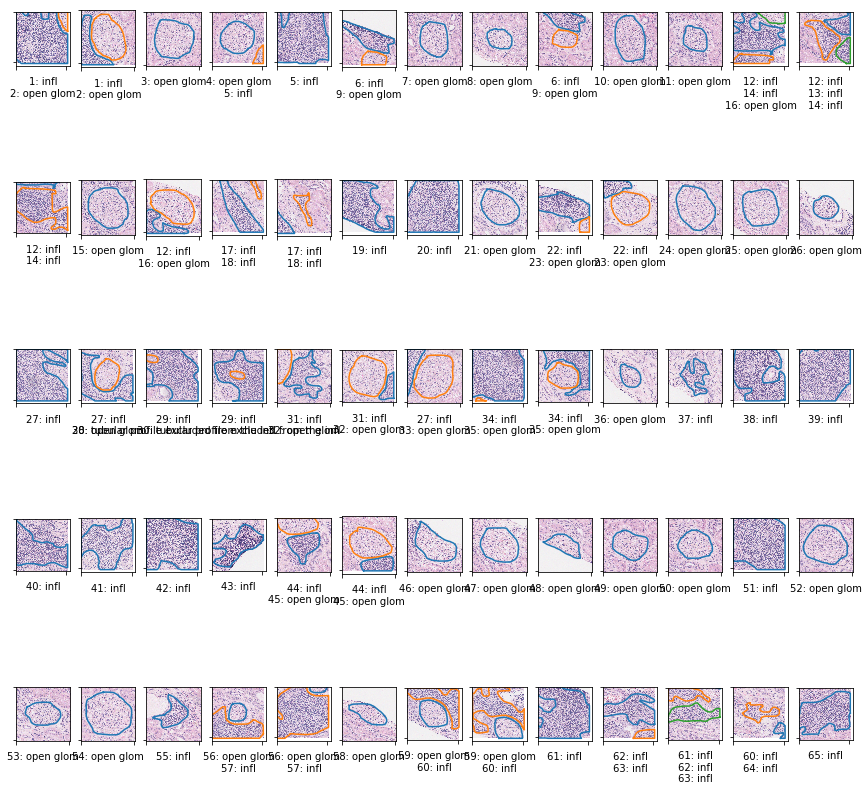

In [57]:
maxarea = 1e7
imgroiiter = read_roi_patches_from_slide(slide, roilist,
                        target_size = [1024]*2,
                        maxarea = maxarea,
                        nchannels=3,
                        allcomponents=True,
                       )

numrois = sum((1 for roi in roilist if not (maxarea is not None and (roi['area'] > maxarea))))
        
visualise_chunks_and_rois(imgroiiter, numrois,
                              nrows = 5, figsize=(15,15)
                             )

## Sample unspecific tissue rois

In [71]:
outdir = "../data/"
os.makedirs(outdir, exist_ok=True)

In [72]:
def save_tissue_chunks(imgroiiter, imgid):
    for ii, (reg, rois,_, start_xy) in enumerate(imgroiiter):
        sumdict = summarize_rois_wi_patch(rois, bg_names = [])
        prefix = get_prefix(imgid, start_xy, sumdict["name"], sumdict["id"], ii)
        fnjson = prefix + ".json"
        fnoutpng = prefix + '.png'
        print(prefix)
        os.makedirs(os.path.dirname(fnjson), exist_ok=True)
        with open(fnjson, 'w+') as fhj: json.dump( sumdict, fhj)
        if isinstance(reg, Image.Image):
            reg.save(fnoutpng)
        else:
            Image.fromarray(reg).save(fnoutpng)

In [73]:
def get_tissue_rois(slide,
                    roilist,
                    vis = False,
                    step = 1024,
                    target_size = None,
                    maxarea = 1e7,
                    random=False,
                   ):

    target_size = [step]*2

    tissue_rois = [roi for roi in roilist if roi['name']=='tissue']

    for roi in tissue_rois:
        print("id", roi["id"])
        cont = roi["vertices"]
        points = sample_points_wi_contour(cont,
                                      step = step,
                                      shift = -step//2,
                                      random=random)

        pointroilist = [{"vertices":[pp], "area":0} for pp in points]
        
#         img_arr, roi_cropped_list, msk_arr, = \
        imgroiiter = read_roi_patches_from_slide(slide, 
                                        pointroilist,
                                        but_list = roilist,
                                        target_size = target_size,
                                        maxarea = maxarea,
                                        color=1,
                                        nchannels=None,
                                        allcomponents = True,
                                        nomask=True,
                                       )
#         if vis:
#             plt.scatter(points[:,0], points[:,1],c='r')
#             plot_contour(cont)
        # filter for rois with only normal tissue 
        normal_tissue_only_iter = filter(lambda x: all(roi['name']=='tissue' for roi in x[1]), imgroiiter )

#         print(next(normal_tissue_only_iter))
        # save
        save_tissue_chunks(normal_tissue_only_iter, imgid)

In [74]:
print("reading and saving (normal) tissue rois")

get_tissue_rois(slide,
                    roilist,
                    vis = False,
                    step = 1024,
                    target_size = None,
                    maxarea = 1e7,
                    random=False,
                   )

reading and saving (normal) tissue rois
id 69


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x14346-y18717-t69-r0-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	capsular tissue	67
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x13322-y20765-t69-r1-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x14346-y20765-t69-r2-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x15370-y20765-t69-r3-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	infl	61
no vertices found	skipping	infl	62
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x15370-y21789-t69-r4-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x16394-y21789-t69-r5-tissue


no vertices found	skipping	tissue	71
../slideslicer/slideutils.py:622: UserWarning: multiple pieces after intersection
using the largest piece

  """)
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x19466-y21789-t69-r6-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x20490-y21789-t69-r7-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x21514-y21789-t69-r8-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x24586-y22813-t69-r9-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x25610-y22813-t69-r10-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x26634-y23837-t69-r11-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x22538-y24861-t69-r12-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x26634-y24861-t69-r13-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	open glom	49
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x29706-y24861-t69-r14-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x30730-y24861-t69-r15-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x25610-y25885-t69-r16-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x27658-y25885-t69-r17-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x30730-y25885-t69-r18-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x31754-y25885-t69-r19-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x32778-y25885-t69-r20-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x29706-y26909-t69-r21-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x30730-y26909-t69-r22-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x31754-y26909-t69-r23-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x32778-y26909-t69-r24-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x31754-y27933-t69-r25-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x32778-y27933-t69-r26-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x33802-y27933-t69-r27-tissue


no vertices found	skipping	open glom	46
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x34826-y27933-t69-r28-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x32778-y28957-t69-r29-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x33802-y28957-t69-r30-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x34826-y28957-t69-r31-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x37898-y28957-t69-r32-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x38922-y28957-t69-r33-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39946-y28957-t69-r34-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x34826-y29981-t69-r35-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x35850-y29981-t69-r36-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x36874-y29981-t69-r37-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x37898-y29981-t69-r38-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x38922-y29981-t69-r39-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39946-y29981-t69-r40-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x40970-y29981-t69-r41-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x41994-y29981-t69-r42-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x43018-y29981-t69-r43-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x37898-y31005-t69-r44-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x38922-y31005-t69-r45-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39946-y31005-t69-r46-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x40970-y31005-t69-r47-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x41994-y31005-t69-r48-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x43018-y31005-t69-r49-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39946-y32029-t69-r50-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x40970-y32029-t69-r51-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x41994-y32029-t69-r52-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x43018-y32029-t69-r53-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x44042-y32029-t69-r54-tissue


no vertices found	skipping	tissue	71
no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x43018-y33053-t69-r55-tissue


no vertices found	skipping	tissue	71


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x44042-y33053-t69-r56-tissue


no vertices found	skipping	tissue	71


id 71
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x2833-y2535-t71-r0-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x3857-y2535-t71-r1-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x4881-y2535-t71-r2-tissue


no vertices found	skipping	infl	1


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x2833-y3559-t71-r3-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x3857-y3559-t71-r4-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x4881-y3559-t71-r5-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x5905-y3559-t71-r6-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x6929-y4583-t71-r7-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x7953-y4583-t71-r8-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x8977-y4583-t71-r9-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x3857-y5607-t71-r10-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x6929-y5607-t71-r11-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x7953-y5607-t71-r12-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x8977-y5607-t71-r13-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x10001-y5607-t71-r14-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc

no vertices found	skipping	infl	5


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x14097-y6631-t71-r20-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x7953-y7655-t71-r21-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x8977-y7655-t71-r22-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x14097-y7655-t71-r23-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x14097-y8679-t71-r24-tissue


no vertices found	skipping	infl	14


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x19217-y8679-t71-r25-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x14097-y9703-t71-r26-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x20241-y9703-t71-r27-tissue


no vertices found	skipping	infl	17


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x22289-y9703-t71-r28-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x16145-y10727-t71-r29-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x17169-y10727-t71-r30-tissue


no vertices found	skipping	open glom	15


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x19217-y10727-t71-r31-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x20241-y10727-t71-r32-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x23313-y10727-t71-r33-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x24337-y10727-t71-r34-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x19217-y11751-t71-r35-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x20241-y11751-t71-r36-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x23313-y11751-t71-r37-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x24337-y11751-t71-r38-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x27409-y11751-t71-r39-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x21265-y12775-t71-r40-tissue


no vertices found	skipping	infl	19


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x24337-y12775-t71-r41-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x27409-y12775-t71-r42-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x28433-y12775-t71-r43-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x29457-y12775-t71-r44-tissue


no vertices found	skipping	infl	20


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x27409-y13799-t71-r45-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x28433-y13799-t71-r46-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x29457-y13799-t71-r47-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x30481-y13799-t71-r48-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x31505-y13799-t71-r49-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x26385-y14823-t71-r50-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x27409-y14823-t71-r51-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x28433-y14823-t71-r52-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x29457-y14823-t71-r53-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x30481-y14823-t71-r54-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x31505-y14823-t71-r55-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x28433-y15847-t71-r56-tissue
data/tissue/f7f9

no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x33553-y17895-t71-r71-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x34577-y17895-t71-r72-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x35601-y17895-t71-r73-tissue


no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x37649-y17895-t71-r74-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x38673-y17895-t71-r75-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39697-y17895-t71-r76-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x40721-y17895-t71-r77-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x35601-y18919-t71-r78-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x36625-y18919-t71-r79-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x37649-y18919-t71-r80-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x38673-y18919-t71-r81-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39697-y18919-t71-r82-tissue


no vertices found	skipping	infl	27
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x40721-y18919-t71-r83-tissue


no vertices found	skipping	tissue	69
no vertices found	skipping	infl	27
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x42769-y18919-t71-r84-tissue


no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39697-y19943-t71-r85-tissue


no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x44817-y19943-t71-r86-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x39697-y20967-t71-r87-tissue


no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69
no vertices found	skipping	infl	27
no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x44817-y20967-t71-r88-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x45841-y20967-t71-r89-tissue


no vertices found	skipping	infl	27
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x40721-y21991-t71-r90-tissue


no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69
no vertices found	skipping	infl	27
no vertices found	skipping	tissue	69
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x44817-y21991-t71-r91-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x45841-y21991-t71-r92-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x46865-y21991-t71-r93-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x47889-y21991-t71-r94-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x42769-y23015-t71-r95-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x43793-y23015-t71-r96-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x44817-y23015-t71-r97-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x48913-y23015-t71-r98-tissue


no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x44817-y24039-t71-r99-tissue


no vertices found	skipping	open glom	32
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x48913-y24039-t71-r100-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x49937-y24039-t71-r101-tissue


no vertices found	skipping	infl	29
no vertices found	skipping	tissue	69


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x45841-y25063-t71-r102-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x48913-y25063-t71-r103-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x49937-y25063-t71-r104-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x50961-y25063-t71-r105-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x47889-y26087-t71-r106-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x48913-y26087-t71-r107-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x48913-y27111-t71-r108-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x53009-y27111-t71-r109-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x49937-y28135-t71-r110-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x50961-y28135-t71-r111-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x51985-y28135-t71-r112-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x53009-y28135-t71-r113-tissue
data

no vertices found	skipping	infl	39


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x53009-y30183-t71-r117-tissue


no vertices found	skipping	infl	39


data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x54033-y30183-t71-r118-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x53009-y31207-t71-r119-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x56081-y31207-t71-r120-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x57105-y31207-t71-r121-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x58129-y31207-t71-r122-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x58129-y32231-t71-r123-tissue
data/tissue/f7f931a5cf3185a385e9aa34e6e9a566fc88000c-x55057-y33255-t71-r124-tissue


In [62]:
# nrows = 5
# nimg = len(roi_cropped_list)
# fig, axs = plt.subplots(nrows, nimg//nrows, figsize=(15,15))
# for ax, reg, rois in zip(axs.ravel(),
#                          img_arr,
#                          roi_cropped_normal_list):
#     ax.imshow(reg)
#     ax.set_xlabel(", ".join(list(set([roi["name"] for roi in rois]))))
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
#     for roi in rois:
#         plot_contour(roi["vertices"], ax=ax)
# #         print(roi["name"], round(roi["areafraction"],2),roi["area"], sep='\t')

In [63]:
# nn = 17
# plt.imshow(img_arr[nn])
# for roi in roi_cropped_list[nn]:
#     plot_contour(roi["vertices"])
#     print(roi["name"], round(roi["areafraction"],2),roi["area"], sep='\t')